<a href="https://colab.research.google.com/github/gaborvecsei/Stocks-Pattern-Analyzer/blob/master/Time_Series_Matcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Flow:
1. Select a stock ticker
2. Select data range
3. Select tickers which we want to include in the similarity analysis
4. Calculate similarities (selected anchor period to similar length periods in the other tickers)
    - Store raw similarities and also some aggregated measure for every ticker
    - Display top-N (most similar) tickers with the values
5. Display top matches on different charts with past and future values applications
6. Display top-N matches normalized on a single chart with past and future values


Idea list:
- Multiple similarity measures
    - Eucledian distance
    - Manhattan distance
    - Day-to-day increase or decrease (binary classification)
    - Selected time period is bearish or bullish
    - Gain/Loss over the period
    - DTW
- Indicators on sell/buy
    - Based on multiple stock pattern similarities, should be buy or sell
    - Predict the gain if I buy today on close value and sell in 1, 7, 14, ... days
    - "64% of the stocks were bearish after this pattern" OR "Min/Max/Average/median gain after this pattern"


Interesting links:
- https://www.intechopen.com/books/advances-in-data-mining-knowledge-discovery-and-applications/similarity-measures-and-dimensionality-reduction-techniques-for-time-series-data-mining

In [1]:
!pip install yfinance stumpy &> /dev/null

In [3]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import json

from sklearn import metrics
import yfinance

import matplotlib.pyplot as plt
%matplotlib inline

In [396]:
# stock_tickers = ["AAPL", "MSFT", "TSLA", "BABA"]
stock_tickers = ["AAPL", "MSFT", "AMZN", "BABA"]

------------------------

In [397]:
def normalize(x):
    return (x - np.min(x))/np.ptp(x)

In [398]:
stock_close_values = dict()

for t in stock_tickers:
    close_vals = yfinance.Ticker(t).history(period="1y", interval="1d")["Close"].values
    stock_close_values[t] = close_vals

In [399]:
# Number of values (days) in the data
{t:x.shape[0] for t, x in stock_close_values.items()}

{'AAPL': 254, 'AMZN': 254, 'BABA': 254, 'MSFT': 254}

In [400]:
ANCHOR_STOCK_TICKER = "TSLA"
WIN = 14

In [401]:
anchor_values = stock_close_values[ANCHOR_STOCK_TICKER]

KeyError: ignored

In [402]:
anchor_series_start = len(anchor_values)-WIN-14
anchor_series_end = anchor_series_start + WIN
anchor_series = anchor_values[anchor_series_start:anchor_series_end]
anchor_series_norm = normalize(anchor_series)

In [343]:
window_len = len(anchor_series)

similarities_dict = dict()

for t, v in stock_close_values.items():
    sims = []
    subseries_indexes = []

    for i in range(0, len(v)-window_len, window_len):
        s = normalize(v[i:i+window_len])
        subseries_indexes.append((i, i+window_len))

        sim = sum(abs(anchor_series_norm - s))
        sims.append(sim)
    
    similarities_dict[t] = {"similarities":sims, "indices":subseries_indexes}

In [344]:
for t in similarities_dict.keys():
    vals = similarities_dict[t]["similarities"]
    top_3 = np.argsort(vals)[:3]
    top_3_with_scores = {a:similarities_dict[t]["similarities"][a] for a in top_3}

    print(f"{t} --> {top_3_with_scores}")

AAPL --> {16: 1.543242261279993, 8: 2.4705857628174503, 3: 2.4884632776572206}
MSFT --> {10: 1.7987308903673749, 14: 2.414930157256342, 3: 2.4583996144716167}
TSLA --> {10: 2.2228693340424655, 15: 2.239086238297434, 8: 3.030642482651856}
BABA --> {13: 2.5355928643439243, 5: 2.6269114527616053, 10: 2.760068117757013}


In [346]:
CHOSEN_CLOSEST_STOCK = "MSFT"
chosen_ticker_values = stock_close_values[CHOSEN_CLOSEST_STOCK]
chosen_ticker_indices = similarities_dict[CHOSEN_CLOSEST_STOCK]["indices"]
chosen_ticker_similarities = similarities_dict[CHOSEN_CLOSEST_STOCK]["similarities"]

In [347]:
closest_series_indexes = chosen_ticker_indices[np.argmin(chosen_ticker_similarities)]

In [348]:
closest_series_start, closest_series_end = closest_series_indexes
closest_series = chosen_ticker_values[closest_series_start:closest_series_end]
closest_series_norm = normalize(closest_series)

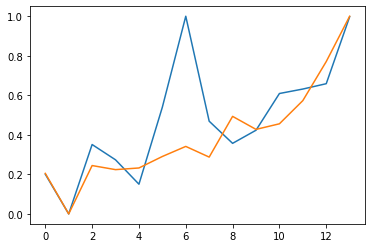

In [349]:
plt.plot(range(0, len(anchor_series_norm)), anchor_series_norm)
plt.plot(range(0, len(closest_series_norm)), closest_series_norm);

In [350]:
FUTURE_WIN = 14
PAST_WIN = 14

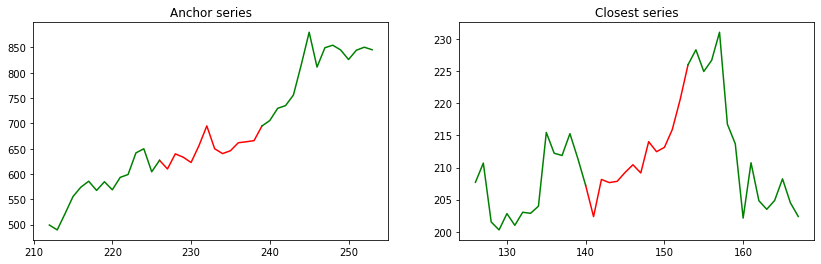

In [351]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

indices_anchor = np.arange(anchor_series_start, anchor_series_end, 1)
indices_anchor_future = np.arange(anchor_series_end-1, anchor_series_end+FUTURE_WIN, 1)
anchor_future = anchor_values[anchor_series_end-1:anchor_series_end+FUTURE_WIN]
indices_anchor_past = np.arange(anchor_series_start-PAST_WIN, anchor_series_start+1, 1)
anchor_past = anchor_values[anchor_series_start-PAST_WIN:anchor_series_start+1]

axs[0].plot(indices_anchor, anchor_series, color="r")
axs[0].plot(indices_anchor_future[:len(anchor_future)], anchor_future, color="g")
axs[0].plot(indices_anchor_past, anchor_past, color="g")
axs[0].set_title("Anchor series")

indices_closest = np.arange(closest_series_start, closest_series_end, 1)
indices_closest_future = np.arange(closest_series_end-1, closest_series_end+FUTURE_WIN, 1)
closest_future = chosen_ticker_values[closest_series_end-1:closest_series_end+FUTURE_WIN]
indices_closest_past = np.arange(closest_series_start-PAST_WIN, closest_series_start+1, 1)
closest_past = chosen_ticker_values[closest_series_start-PAST_WIN:closest_series_start+1]

axs[1].plot(indices_closest, closest_series, color="r")
axs[1].plot(indices_closest_future, closest_future, color="g")
axs[1].plot(indices_closest_past, closest_past, color="g")
axs[1].set_title("Closest series");

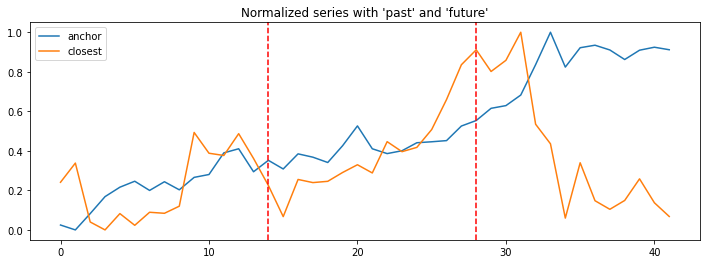

In [352]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(normalize(anchor_values[anchor_series_start-PAST_WIN:anchor_series_end+FUTURE_WIN]), label="anchor")
ax.plot(normalize(chosen_ticker_values[closest_series_start-PAST_WIN:closest_series_end+FUTURE_WIN]), label="closest")
ax.axvline(x=PAST_WIN, color="r", linestyle="--")
ax.axvline(x=PAST_WIN+WIN, color="r", linestyle="--")
ax.set_title("Normalized series with 'past' and 'future'")
ax.legend();

-------------------------

In [199]:
class TickerHelper:
    def __init__(self, ticker:str):
        self.name = ticker

        self._data = yfinance.Ticker(self.name).history(period="1y", interval="1d")

        self.dates = self._data.index
        self.close_vals = self._data["Close"].values.astype(np.float32)

    def get_windows(self, win_size:int):
        stock_windows = []
        for i in range(0, len(self) - win_size, win_size):
            stock_windows.append(StockWindow(self, i, i+win_size))
        return stock_windows

    def __len__(self):
        return len(self.close_vals)

In [200]:
class StockWindow:
    def __init__(self, ticker:TickerHelper, start_index:int=None, end_index:int=None):
        self.ticker = ticker
        self.start_index = start_index
        self.end_index = end_index

    @property
    def values(self):
        return self.ticker.close_vals[self.start_index:self.end_index]

    def with_past_and_future(self, past_win_size:int, future_win_size:int):
        return StockWindow(self.ticker, self.start_index-past_win_size, self.end_index+future_win_size)

    def future(self, win_size:int):
        # TODO: what if there is no future?
        return StockWindow(self.ticker, self.end_index, self.end_index+win_size)

    def past(self, win_size:int):
        # TODO: what if there is no past?
        return StockWindow(self.ticker, self.start_index-win_size, self.start_index)

    @property
    def norm_values(self):
        return normalize(self.values)

    @property
    def dates(self):
        return self.ticker.dates[self.start_index:self.end_index]

    def __len__(self):
        return self.end_index - self.start_index

In [201]:
class DistanceEntry:
    def __init__(self, stock_window:StockWindow, window_index:int, distance:float):
        self.window_index = window_index
        self.distance = distance
        self.stock_window = stock_window

    def __repr__(self):
        return f"window_index: {self.window_index}, distance: {self.distance}"

In [202]:
class Distance:
    def __init__(self, anchor:StockWindow, other_tickers:list):
        self.anchor = anchor
        self.other_tickers = other_tickers

        self.distance_dict = dict()

    @staticmethod
    def similarity_metric(anchor_vals, other_vals):
        assert len(anchor_vals) == len(other_vals), "Length of series should be the same"
        return np.sum(np.abs(anchor_vals - other_vals))

    def compute_distance(self):
        self.distance_dict = {}

        for ticker in self.other_tickers:
            self.distance_dict[ticker.name] = []

            for window in ticker.get_windows(win_size=len(self.anchor)):
                distance_value = self.similarity_metric(self.anchor.norm_values, window.norm_values)
                self.distance_dict[ticker.name].append(distance_value)
        
        return self.distance_dict

    def top_K_matches_for_ticker(self, ticker:TickerHelper, K:int):
        dist_values = self.distance_dict[ticker.name]
        top_K_indices = np.argsort(dist_values)[:K]

        stock_windows = ticker.get_windows(win_size=len(self.anchor))

        distance_entries_sorted = []
        for i in top_K_indices:
            distance_entries_sorted.append(DistanceEntry(stock_windows[i], i, dist_values[i]))

        return distance_entries_sorted

    def top_K(self, K:int, order_by_first_distance_values:bool=True):
        res_dict = {}
        for t in self.other_tickers:
            # TODO: This can run in parallel
            res_dict[t.name] = self.top_K_matches_for_ticker(t, K)
        # Sort the Tickers based on the first distance value
        if order_by_first_distance_values:
            return OrderedDict(sorted(res_dict.items(), key=lambda x: x[1][0].distance))
        else:
            return res_dict

In [276]:
stock_tickers = ["AAPL", "MSFT", "TSLA", "BABA"]

In [403]:
tickers_dict = {k:TickerHelper(k) for k in stock_tickers}

In [404]:
{k:len(v) for k, v in tickers_dict.items()}

{'AAPL': 254, 'AMZN': 254, 'BABA': 254, 'MSFT': 254}

In [405]:
ANCHOR_STOCK_TICKER = "BABA"
WINDOW_SIZE = 14
OFFSET = 0

anchor_ticker = tickers_dict[ANCHOR_STOCK_TICKER]
anchor_series = StockWindow(anchor_ticker, len(anchor_ticker)-WINDOW_SIZE-OFFSET, len(anchor_ticker)-OFFSET)

In [376]:
dist = Distance(anchor_series, tickers_dict.values())
_ = dist.compute_distance()

In [377]:
top_K_matches = dist.top_K(1, True)

In [378]:
top_K_matches

OrderedDict([('BABA', [window_index: 10, distance: 1.6636543273925781]),
             ('AAPL', [window_index: 6, distance: 1.9032108783721924]),
             ('MSFT', [window_index: 10, distance: 1.9054509401321411]),
             ('TSLA', [window_index: 6, distance: 2.26770281791687])])

In [379]:
# Get the top series match from the top stock match
closest_stock_window = next(iter(top_K_matches.values()))[0].stock_window

In [380]:
def visualize_similarity(anchor:StockWindow, top_K_matches:OrderedDict, past_window:int=0, future_window:int=0, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(14, 4))

    ax.set_ylabel("Norm values")
    ax.set_xlabel("Date (of the anchor stock)")

    for ticker_name, top_matched_series in top_K_matches.items():
        # Get the top match for each ticker
        for match in top_matched_series:
            stock_window_extended = match.stock_window.with_past_and_future(past_window, future_window)
            try:
                ax.plot(stock_window_extended.norm_values, color="blue", linestyle="--")
            except:
                print(f"Could not plot {ticker_name} with window index of {match.window_index}")

    
    anchor_extended = anchor.with_past_and_future(past_window, future_window)
    ax.plot(anchor_extended.norm_values, label="anchor", color="red")

    ax.axvline(x=past_window, color="r", linestyle="--")
    ax.axvline(x=past_window+len(anchor), color="r", linestyle="--")
    ax.set_title("Normalized series with 'past' and 'future'")
    ax.legend();

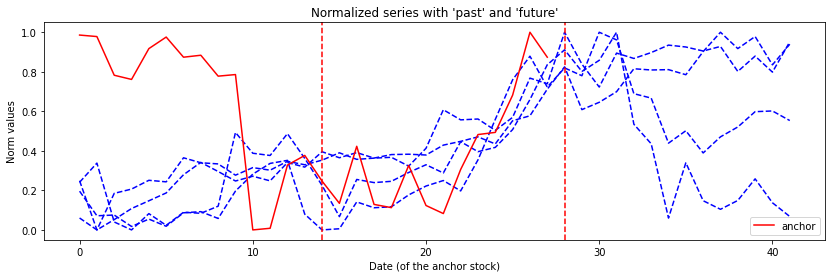

In [381]:
visualize_similarity(anchor_series, top_K_matches, 14, 14)

In [382]:
# TODO: we should be able to plot by tickers, and by the best matches in order with modifying alpha

-----------------------------------

In [433]:
df = yfinance.download(stock_tickers, period="1y", interval="1d")

[*********************100%***********************]  4 of 4 completed


In [434]:
df = df["Close"]

In [435]:
win_size = WINDOW_SIZE
anchor_ticker = ANCHOR_STOCK_TICKER
anchor_series = df[-win_size:][anchor_ticker]
if OFFSET > 0:
    anchor_series = df[-win_size-OFFSET:-OFFSET][anchor_ticker]
anchor_vals = anchor_series.values.reshape(-1, 1)

In [436]:
def normalize(x, axis=0):
    # If axis=0 then columns are normalized, if it is 1 then rows
    return (x - np.min(x, axis=axis)) / np.ptp(x, axis=axis)

In [437]:
def period_trend(values:np.ndarray):
    return np.where(values[-1, :] - values[0, :] > 0, 1, 0)


def day_to_day_trend(series:pd.Series):
    return np.where(series.rolling(2).apply(lambda x: x[1]-x[0])[1:].values > 0, 1, 0)

In [438]:
distance_values = []
period_trend_similarities = []
day_to_day_trend_similarities = []
start_dates = []
end_dates = []

# Precomputed values
anchor_period_trend_indicator = period_trend(anchor_vals)
anchor_day_to_day_trend_indicator = day_to_day_trend(anchor_series).reshape(-1, 1)

row_index = 0

for i in range(0, len(df)-win_size, 1):
    sub_df = df[i:i+win_size]
    dates = sub_df.index.values

    start_dates.append(dates[0])
    end_dates.append(dates[-1])

    # Distance calculation per column (ticker)
    # It can happen that the "left over" is not long enough, this is wht we "crop" the anchor values
    dist_vals = np.sum(np.abs(normalize(sub_df.values) - normalize(anchor_vals)), axis=0)
    distance_values.append(dist_vals)

    # Trend direction similarity per column (ticker)
    # The first and last value determines what was the direction for the given time period - ($first_day - last_day$)
    period_trend_indicators = period_trend(sub_df.values)
    period_trend_similarity = np.abs(period_trend_indicators - anchor_period_trend_indicator)
    period_trend_similarities.append(period_trend_similarity)

    # Day-to-day "trend" similarity
    day_to_day_trend_indicators = day_to_day_trend(sub_df)
    day_to_day_trend_similarity = np.abs(day_to_day_trend_indicators - anchor_day_to_day_trend_indicator)
    day_to_day_trend_similarity = np.sum(day_to_day_trend_similarity, axis=0)
    day_to_day_trend_similarities.append(day_to_day_trend_similarity)

    row_index += 1


In [439]:
# This DataFrame contains the MAE differences
dist_res_df = pd.DataFrame(distance_values, columns=df.columns)
dist_res_df["start_date"] = start_dates
dist_res_df["end_date"] = end_dates

In [440]:
# This DataFrame contains 1s where there is a difference in period trend compared
# with the anchor series
period_sim_res_df = pd.DataFrame(period_trend_similarities, columns=df.columns)
period_sim_res_df["start_date"] = start_dates
period_sim_res_df["end_date"] = end_dates

In [441]:
# This DataFrame contains other than zero values, where there is a difference
# in the day to day trends
day_to_day_sim_df = pd.DataFrame(day_to_day_trend_similarities, columns=df.columns)
day_to_day_sim_df["start_date"] = start_dates
day_to_day_sim_df["end_date"] = end_dates

In [442]:
day_to_day_weight = 0.5
period_weight = 0.5

day_to_day_vals = day_to_day_sim_df[stock_tickers].values.copy() * day_to_day_weight + 1
period_vals = period_sim_res_df[stock_tickers].values.copy() * period_weight + 1

similarity_df = dist_res_df[stock_tickers] * day_to_day_vals * period_vals
# similarity_df = dist_res_df[stock_tickers]
similarity_df["start"] = dist_res_df["start_date"]
similarity_df["end"] = dist_res_df["end_date"]

In [443]:
def visualize_similarity_for_ticker(anchor_series:pd.Series,
                                    stock_df:pd.DataFrame,
                                    similarity_df:pd.DataFrame,
                                    K:int,
                                    interesting_tickers:list,
                                    past_window:int=0,
                                    future_window:int=0,
                                    ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(14, 4))

    if interesting_tickers is None:
        interesting_tickers = similarity_df.columns

    for c in interesting_tickers:
        most_similar_window_dates = similarity_df.sort_values(c)[:K][["start", "end"]]

        for start, end in most_similar_window_dates.values:
            # Extend the search window with past and future
            start_index = stock_df.index.get_loc(start) - past_window
            end_index = stock_df.index.get_loc(end) + future_window
            if start_index < 0:
                start_index = 0

            sub_df = stock_df.iloc[start_index : end_index]
            vals = sub_df[c].values
            ax.plot(normalize(vals), color="blue", linestyle="--")


    s, e = anchor_series.index.values[[0, -1]]
    s = stock_df.index.get_loc(s) - past_window
    e = stock_df.index.get_loc(e) + future_window
    if s < 0:
        s = 0
    extended_anchor_series = stock_df.iloc[s:e][anchor_ticker]
    ax.plot(normalize(extended_anchor_series.values), label="anchor", color="red")
    
    ax.axvline(x=past_window, color="r", linestyle="--")
    ax.axvline(x=past_window+len(anchor_series), color="r", linestyle="--")
    ax.set_title("Normalized series with 'past' and 'future'")

    ax.set_ylabel("Normalized values")
    ax.set_xlabel("Date (of the anchor stock)")

    ax.legend();

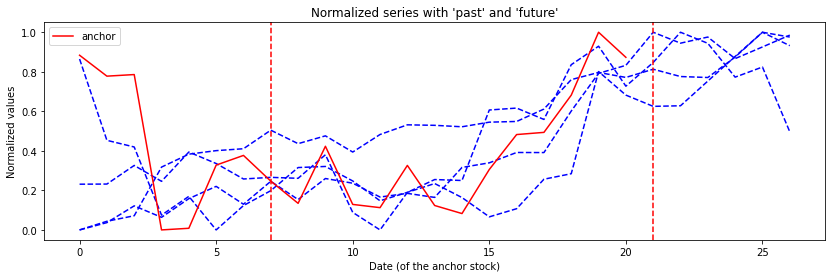

In [446]:
visualize_similarity_for_ticker(anchor_series, df, similarity_df, 1, stock_tickers, 7, 7)